In [1]:
import numpy as np
import random
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from joblib import dump

import itertools
from sklearn.utils import shuffle
from scipy import signal
%matplotlib inline


from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectFdr, chi2

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

from utils.svm import preProcess
from utils.visualize import showMe
%load_ext autoreload
%autoreload 2


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
input_length = 100
resource_path = 'C:/resources/EMG/'
post_fix = '_1s_augmented'
# train_sessions = ['session_0','session_1', 'session_2', 'session_3']
# test_sessions  = ['session_0','session_1', 'session_2', 'session_3', 'session_4']

train_sessions = ['03_02/session_0']
test_sessions  = ['03_02/session_0']

classes = ['Rest', 'Eyebrow','Smile', 'Chew']

records = {}
for session in train_sessions:
    for c in classes:
        asd = np.load(os.path.join(resource_path,session,c+post_fix+'.npy'),allow_pickle=True)
        print(asd.shape)
        records[c] = asd

# for record in records:
#     records[record] = np.concatenate((records[record]), axis=2)
#     print(records[record].shape)

# rests = preProcess(rests, input_length)
# eyebrows = preProcess(eyebrows, input_length)
# chews = preProcess(chews, input_length)

(90, 6, 100)
(90, 6, 100)
(90, 6, 100)
(90, 6, 100)


In [5]:
def showFirstN(data, limit = 5):
    i = 0
    for trial in data:
        showMe(trial)
        if i == 5:
            break
        i += 1


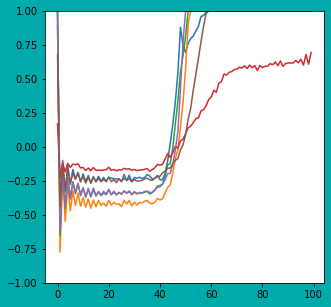

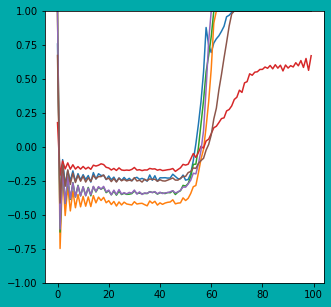

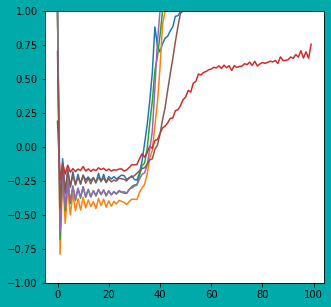

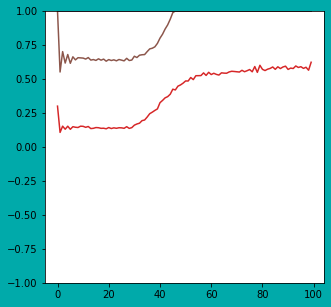

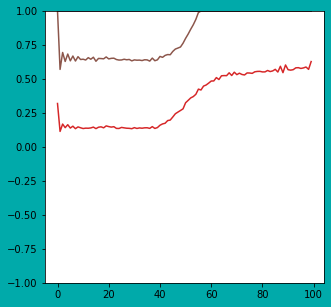

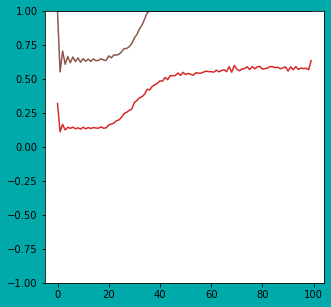

In [8]:
showFirstN(records['Eyebrow'])

In [10]:
for r in records:
    print(records[r].shape)

(30, 6, 100)
(30, 6, 100)
(30, 6, 100)
(30, 6, 100)


In [10]:
# X = np.concatenate((rests,eyebrows,chews),axis = 0)
# y = np.concatenate(( np.zeros(rests.shape[0]),np.ones(eyebrows.shape[0]),np.ones(eyebrows.shape[0])*2))

X = np.concatenate((records['Rest'], records['Eyebrow'], records['Smile'], records['Chew']),axis = 0)
#X = np.concatenate((records.items()),axis = 0)

s = records['Rest'].shape[0]

y = np.concatenate(( np.zeros(s),np.ones(s),np.ones(s)*2,np.ones(s)*3))


c = list(zip(X, y))
random.seed(42)
random.shuffle(c)
X,y = zip(*c)


X = np.array(X).reshape(-1,6*input_length)
y = np.array(y)

print(X.shape)
print(y.shape)

(360, 600)
(360,)


In [11]:
param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100,1000], 'gamma': [10,1,0.1,0.01,0.001,0.0001]} 

In [12]:
accs = []
models = []
def grid(X_train,y_train, X_test, y_test):
    grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
    grid.fit(X_train,y_train)

    grid_predictions = grid.predict(X_test)
    acc = accuracy_score(y_test,grid_predictions)
    accs.append(acc)
    models.append(grid.best_estimator_)
    if acc > 0.9:
        return True
    else:
        return False


skf = StratifiedKFold(n_splits=10,random_state= 42, shuffle = True)
for train, test in skf.split(X, y):
    
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]

    if grid(X_train,y_train, X_test, y_test):
        break
    

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..................................C=0.001, gamma=10; total time=   0.0s
[CV] END ..................................C=0.001, gamma=10; total time=   0.0s
[CV] END ..................................C=0.001, gamma=10; total time=   0.0s
[CV] END ..................................C=0.001, gamma=10; total time=   0.0s
[CV] END ..................................C=0.001, gamma=10; total time=   0.0s
[CV] END ...................................C=0.001, gamma=1; total time=   0.0s
[CV] END ...................................C=0.001, gamma=1; total time=   0.0s
[CV] END ...................................C=0.001, gamma=1; total time=   0.0s
[CV] END ...................................C=0.001, gamma=1; total time=   0.0s
[CV] END ...................................C=0.001, gamma=1; total time=   0.0s
[CV] END .................................C=0.001, gamma=0.1; total time=   0.0s
[CV] END .................................C=0.0

In [13]:
model = models[accs.index(max(accs))]
for acc in accs:
    print(acc)

0.9722222222222222


In [14]:
def evaluate(session, input_length =100):
    rests    = np.load(resource_path+session+'/Rest.npy')
    eyebrows = np.load(resource_path+session+'/Eyebrow.npy')
    chews    = np.load(resource_path+session+'/Chew.npy')

    rests = preProcess(rests,input_length)
    eyebrows = preProcess(eyebrows,input_length)
    chews = preProcess(chews,input_length)

    rests = rests.reshape(-1,6*input_length)
    eyebrows = eyebrows.reshape(-1,6*input_length)
    chews = chews.reshape(-1,6*input_length)
    

    correct = 0
    incorrect = 0

    for r in rests:
        if abs(0-model.predict([r]))<0.5:
            correct+=1
        else:
            incorrect+=1
    
    for r in eyebrows:
        if abs(1-model.predict([r]))<0.5:
            correct+=1
        else:
            incorrect+=1
    
    for r in chews:

        if abs(2-model.predict([r]))<0.5:
            correct+=1
        else:
            incorrect+=1

            
    print('Total:{}, correct:{}, acc:{}%'.format(correct+incorrect,correct,round(correct/(correct+incorrect),2)*100))

    

In [15]:
for session in test_sessions:
    print("Evaluating session: {}".format(session))
    evaluate(session)

Evaluating session: 03_02/session_0


FileNotFoundError: [Errno 2] No such file or directory: 'C:/resources/EMG/03_02/session_0/Rest.npy'

In [16]:
dump(model, 'saved_models/svm_03_02.joblib') 

['saved_models/svm_03_02.joblib']